# Histopathologic Cancer Detection

## 1. Problem Discussion
The central challenge of this project is to detect metastatic cancer in small pathology images. These images are critical for identifying the presence of metastatic tissue, which plays a key role in cancer diagnosis. A positive label in this classification task signifies that the central 32x32 pixel region of an image patch contains at least one pixel of tumor tissue. Importantly, tumor tissue located outside this central region does not affect the label.

Machine learning, particularly through Convolutional Neural Networks (CNNs), has become integral to medical imaging and diagnostics. These algorithms offer the promise of swift and precise detection, significantly enhancing clinical workflows.

### 1.1 Data Description
The dataset includes the following components:

#### Images
The dataset consists of small pathology images. While the exact resolution is not specified, the nature of the task and comparisons to datasets like CIFAR-10 and MNIST suggest the images are relatively low-resolution. The classification task is focused on the central 32x32 pixel area.

#### Labels
The labels are binary:

##### Positive: Indicates that the central region contains tumor tissue.
##### Negative: Indicates the absence of tumor tissue in the central region.

#### Files
Training Data:

##### Images: Stored in the train folder.
##### Labels: Provided in train_labels.csv.

#### Test Data:
Images: Stored in the test folder, where predictions are required.
Given the importance of this task, machine learning models trained on this dataset hold the potential to transform early cancer detection. They can provide faster and more accurate diagnoses, paving the way for improved clinical outcomes.


##### We start by importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam,SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import models
from keras.models import Model
import random
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, concatenate, Add, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

/var/folders/xb/qwgsqylj7j7c10t_q8rvnf_c0000gn/T/ipykernel_1633/1023734559.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


##### GPU Availability Check  

This script determines whether TensorFlow is utilizing a GPU (Graphics Processing Unit) for computation. GPUs can dramatically accelerate neural network processing, making them invaluable for deep learning tasks.  

- **If a GPU is detected**: The script will display the GPU's name.  
- **If no GPU is detected**: The script will recommend installing the GPU-optimized version of TensorFlow to enhance performance.  


In [2]:
# Check for GPU availability
if tf.test.gpu_device_name():
    # If GPU is available, display its name
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    # If not, prompt the user to use the GPU version of TensorFlow
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2024-12-30 13:03:33.589796: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-30 13:03:33.589843: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-30 13:03:33.589864: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-30 13:03:33.590375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-30 13:03:33.590876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-30 13:03:33.593836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built wit

## 2 Exploratory Data Analysis (EDA)  

### 2.1 Initial Data Inspection  
Before diving into complex visualizations, the first step in the data analysis process is to thoroughly understand the dataset. This involves examining its structure, identifying any missing values, and summarizing its basic statistical properties. This foundational inspection ensures that subsequent analyses are accurate and relevant.  

The following steps outline the initial exploration of the histopathologic cancer detection dataset:  

- **Necessary Libraries**: The `pandas` library, essential for data manipulation and analysis, is imported.  
- **Loading the Data**: The dataset is read from a CSV file using `pandas` and stored in the `data` variable.  
- **Quick Overview**: The `head()` function is used to display the first few rows, providing a snapshot of the dataset's structure.  
- **Statistical Summary**: The `describe()` function generates a detailed statistical summary, including metrics such as count, mean, standard deviation, and percentiles.  
- **Missing Data Check**: To ensure data integrity, the dataset is checked for missing values. Using `isnull()` combined with `sum()`, a column-wise report is generated to identify any missing entries.  


In [3]:
# Load the dataset containing id and label of the training samples
training_labels=pd.read_csv('histopathologic-cancer-detection 2/train_labels.csv')

# Dislplay the head of the dataset
print(training_labels.head())

# Provide a statistical summary of the dataset
print(training_labels.describe())

# Check for and display any missing values in the dataset
print(training_labels.isnull().sum())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
id       0
label    0
dtype: int64


### 2.2 Visualizations  

#### 2.2.1 Histograms  
The following code leverages `matplotlib`, a widely-used plotting library, to explore the distribution of labels in the dataset:  

- **Library**: The `matplotlib.pyplot` module is used, providing functions for creating and embedding visualizations.  
- **Label Distribution Visualization**: The `value_counts()` function calculates the frequency of each label in the `label` column. These frequencies are then visualized using the `plot()` function to create a bar chart.  
- **Displaying the Plot**: The `show()` function is called to render and display the plot to the user.  


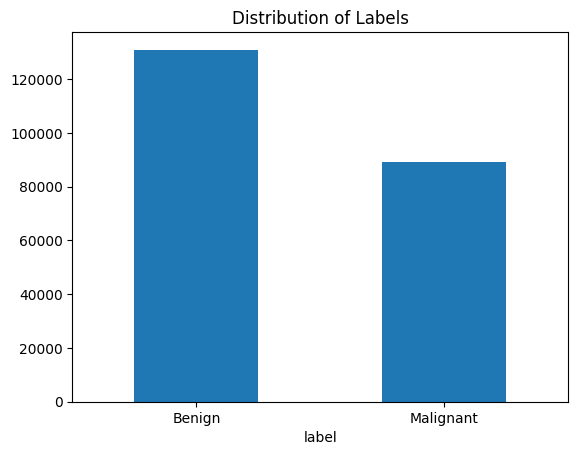

In [4]:
# Visualizing the distribution of labels
training_labels['label'].value_counts().plot(kind='bar', title='Distribution of Labels')  # Generating a bar chart of the label frequencies
plt.xticks([0, 1], ['Benign', 'Malignant'], rotation=0)
plt.show()  # Displaying the plot

In [5]:
#Load the training images
train_dir='histopathologic-cancer-detection 2/train'

training_data= [] 
def create_training_data(dir):
    for img in os.listdir(train_dir):
        img_array=cv2.imread(os.path.join(dir,img))
        training_data.append(img_array)
        
create_training_data(train_dir) 

#### 2.2.2 Image Visualizations  

This section aims to enhance understanding of the dataset by displaying random images from the training set.  

- **Libraries Used**:  
  - `os` and `random` libraries are used for file navigation and random sampling.  
  - `PIL` (Python Imaging Library) is utilized for image manipulation and rendering.  

- **Visualizing Random Images**:  
  The `visualize_random_images` function implements the following steps:  
  - **Random ID Selection**: Randomly selects a specified number of image IDs using the `random.sample()` function.  
  - **Image Display Loop**: Iterates through the selected IDs, accesses the corresponding images, and displays them in subplots.  
  - **Image Labeling**: Labels each image with its classification, displayed as the title of the subplot.  
  - **Layout and Rendering**: Arranges the images neatly using `tight_layout()` and renders the visualization with `show()`.  

- **Execution**:  
  The function is called to display 5 random images from the training dataset, providing a visual overview of the data.  


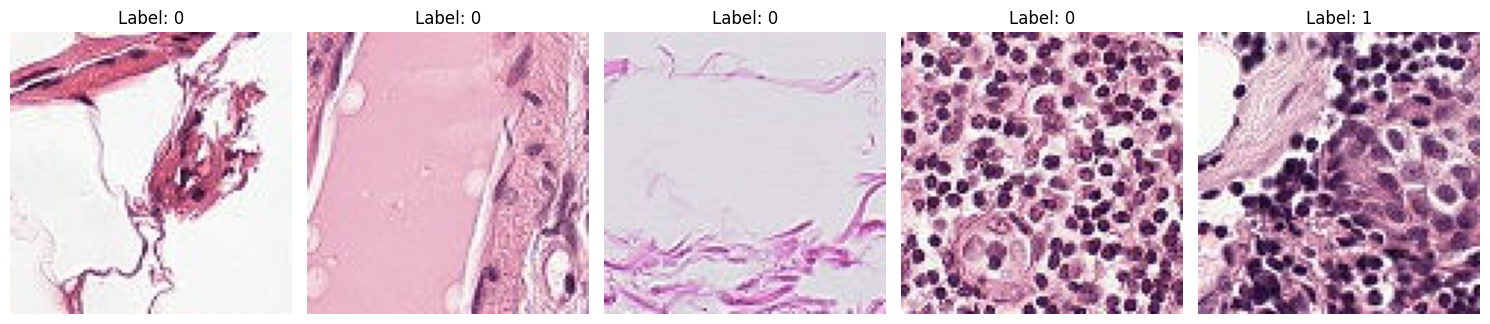

In [6]:
# Function to visualize random images from the dataset
def visualize_random_images(data, num_images=5):
    # Selecting random image IDs from the dataset
    random_ids = random.sample(list(data['id']), num_images)
    plt.figure(figsize=(15, 5))
    
    # Looping through the random image IDs to display them
    for i, img_id in enumerate(random_ids):
        img_path = os.path.join(train_dir, img_id + '.tif')  # Constructing the full image path
        img = Image.open(img_path)  # Opening the image using PIL
        plt.subplot(1, num_images, i + 1)  # Adding a subplot for each image
        plt.imshow(img)  # Displaying the image
        # Displaying the label of the image as its title
        plt.title(f"Label: {data[data['id'] == img_id]['label'].values[0]}")
        plt.axis('off')  # Turning off the axis to make the visualization cleaner
    plt.tight_layout()  # Ensuring the layout is clean and non-overlapping
    plt.show()  # Rendering the visualization

# Displaying 5 random images from the dataset
visualize_random_images(training_labels)

#### 2.2.3 Heatmap Visualization  

This section demonstrates how to create an "Average Heatmap" that consolidates pixel-level data from multiple images, revealing common patterns across the dataset.  

- **Function Definition (`calculate_average_heatmap`)**:  
  The function computes the average heatmap by performing the following steps:  
  - **Random Sampling**: A random subset of image IDs is selected.  
  - **Pixel Accumulation**: The pixel values of each selected image are summed during iteration.  
  - **Average Computation**: The accumulated pixel values are divided by the number of images to calculate the average heatmap.  

- **Calculation and Display**:  
  - The function is called to compute the average heatmap for images in the training dataset.  
  - Using `matplotlib`, the average heatmap is visualized. The heatmap highlights areas of commonality or prominence across sampled images, with a color bar indicating pixel intensity values.  


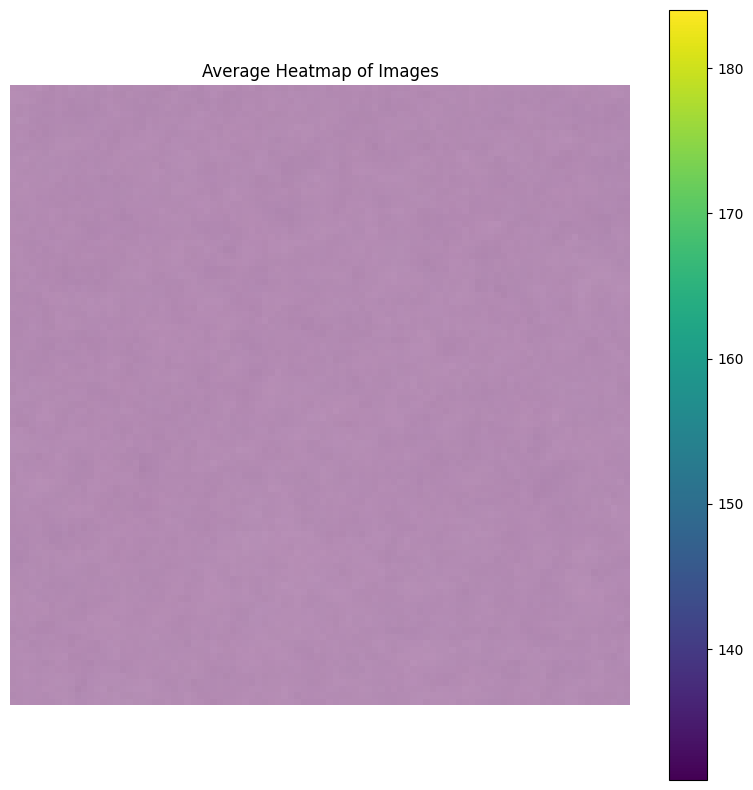

In [7]:
# Function to calculate the average heatmap for a set of images
def calculate_average_heatmap(directory, num_samples=1000):
    # Select a random subset of image IDs from the dataset
    random_ids = random.sample(list(training_labels['id']), num_samples)
    # Initialize a matrix with zeros to accumulate the pixel values of the images
    sum_images = np.zeros((96, 96, 3))
    
    # Loop over each random image ID
    for img_id in random_ids:
        img_path = os.path.join(directory, img_id + '.tif')  # Construct the image path
        img = Image.open(img_path)  # Load the image using PIL
        img_arr = np.array(img)  # Convert the image to a numpy array
        sum_images += img_arr  # Add the pixel values of the image to the sum
        
    # Calculate the average pixel values by dividing the sum by the number of samples
    avg_image = sum_images / num_samples
    return avg_image

# Calculate the average heatmap for the train images
avg_image = calculate_average_heatmap(train_dir)

# Display the average heatmap
plt.figure(figsize=(10, 10))
plt.imshow(avg_image.astype(int))  # Convert the floating point values to integers for display
plt.title('Average Heatmap of Images')
plt.colorbar()  # Display the colorbar for the heatmap
plt.axis('off')  # Hide the axis
plt.show()  # Render the visualization

## 3 Model Architecture  

### 3.1 MNIST-Inspired Baseline Model  
The MNIST dataset, a cornerstone of image classification, provides a foundational framework for classifying images. While our dataset is more complex and significantly larger than MNIST, adopting a model inspired by its architecture offers a pragmatic starting point. This baseline enables us to benchmark subsequent refinements and assess improvements brought by more sophisticated models.  

### 3.2 Transfer Learning  

### Embracing Transfer Learning  

With the evolution of deep learning, numerous pre-trained models have emerged, trained on extensive datasets like ImageNet. These models have already learned a broad spectrum of features that can be adapted to specific tasks. Through **Transfer Learning**, we can fine-tune these pre-trained models by modifying only the final layers to align with our dataset. This approach offers significant benefits:  
- **Efficiency**: Training time is reduced as the foundational features are pre-learned.  
- **Performance**: Leveraging the latent knowledge of pre-trained models often results in superior accuracy, particularly when working with smaller datasets.  

---

## 4 Model Training and Hyperparameter Optimization  

This section focuses on training and optimizing the models discussed earlier. Our objective is to achieve peak performance through structured training and meticulous hyperparameter tuning.  

### 4.1 Building the MNIST-Inspired Model  

Here, we construct and train the MNIST-inspired baseline model:  

- **Design Rationale**:  
  The model is influenced by proven architectures from the MNIST dataset. MNIST's reputation as a benchmark in image classification provides a solid starting point for our efforts.  

- **Layer Sequence**:  
  Sequential layers are designed for image recognition tasks, incorporating convolutional, pooling, and dense layers to extract and process features effectively.  

- **Parameters**:  
  Key parameters, such as filter sizes, pooling strategies, and activation functions, are configured based on best practices derived from the MNIST dataset.  

- **Optimization Strategy**:  
  A loss function, optimizer, and relevant metrics for binary 

In [9]:
# Overall Goal: Construct a model that leverages the MobileNetV2 architecture (pre-trained on ImageNet) as a feature extractor 
# and appends custom dense layers for binary classification on our dataset.

# Load the MobileNetV2 model but exclude the classification layers
# This provides us with a powerful feature extractor pretrained on ImageNet
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
# Ensures that the weights of the pretrained model do not change during our training process
for layer in base_model.layers:
    layer.trainable = False

# Extend the architecture by adding custom layers 
# These layers will be responsible for making predictions based on the features extracted by MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)     # Reduces spatial dimensions, focusing on main features
x = Dense(128, activation='relu')(x) # Fully connected layer for deeper pattern recognition
x = Dropout(0.2)(x)                  # Helps prevent overfitting by dropping some activations
predictions = Dense(1, activation='sigmoid')(x) # Final output layer for binary classification

# Compile the model with a binary cross-entropy loss function and the Adam optimizer
# This sets up our model for training on our binary classification task
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

### 4.2 Building the Xception 
We use the Xception model, as a more advanced model than the MNIST inspired model in order to have better model for inference. The base model is loaded with the Xception class from Keras, and its output is passed through a global average pooling layer to reduce the spatial dimensions. The resulting feature vector is then processed by a sequence of dense layers with ReLU activation, dropout layers to prevent overfitting, and a batch normalization layer to stabilize the training process. The final output is a single value predicted by a dense layer with a sigmoid activation function, making it suitable for binary classification tasks.

In [10]:
# Define the image shape
img_shape = (96, 96, 3)

# Load the Xception base model
base_model_Xception = Xception(include_top=False, weights='imagenet', input_shape=img_shape)

# Add layers using Functional API
x = GlobalAveragePooling2D()(base_model_Xception.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid')(x)

model_Xception = Model(inputs=base_model_Xception.input, outputs=outputs)

model_Xception.summary() #Model Summary

model_Xception.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                 metrics=[AUC(name='auc')]) # Compile Model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 47, 47, 32)           864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 47, 47, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 47, 47, 32)           0         ['block1_conv1_bn[0][0]'

### 4.3 Data Preparation for Model Training  

This subsection covers the preprocessing steps necessary to prepare the dataset for effective model training:  

- **Data Splitting**:  
  The dataset is divided into training, validation, and test sets to ensure a robust evaluation of model performance.  

- **Normalization**:  
  Pixel values are scaled to a range of 0 to 1 to standardize the data and improve convergence during training.  

- **Augmentation**:  
  Techniques such as rotation, zoom, and horizontal flipping are applied to increase dataset size and variability, reducing overfitting and improving model generalization.  

- **Batching**:  
  The data is organized into mini-batches to enhance training efficiency and optimize memory usage.  

In [11]:
# Define batch size. It will determine how many images to process at a time in the data generators.
BATCH_SIZE = 32  # Must match with the 'batch_size' parameter of the ImageDataGenerator.

# Load and Prepare Data:
# Construct the full path to the image files based on their IDs.
training_labels['path'] = 'histopathologic-cancer-detection 2/train/' + training_labels['id'] + '.tif'
print(training_labels['path'])
# Convert the labels to string format for compatibility with ImageDataGenerator.
training_labels['label'] = training_labels['label'].astype(str)

# Image Augmentation:
# This is to artificially expand the size of the training dataset by creating modified versions of images in the dataset.
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    horizontal_flip=True,       # Randomly flip images horizontally
    vertical_flip=True,         # Randomly flip images vertically
    rotation_range=20,          # Randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.15,            # Randomly zoom image 
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.15,           # Shear intensity (Shear angle in counter-clockwise direction in degrees)
    validation_split=0.2        # Reserve 20% of the data for validation
)

# Training Data Generator:
# This will supply batches of images and labels to the training process.
train_generator = datagen.flow_from_dataframe(
    dataframe=training_labels,  # DataFrame containing file paths and labels
    x_col="path",               # Column in the dataframe that contains the file paths for the training images
    y_col="label",              # Column in the dataframe that contains the labels
    subset="training",          # Specify that this generator is for training data
    batch_size=BATCH_SIZE,      # Size of batches the generator should produce
    seed=42,                    # Random seed for reproducibility
    shuffle=True,               # Shuffle the data to present different batches in each epoch
    class_mode="binary",        # As we are doing binary classification
    target_size=(96, 96))       # Resize images to this size

# Validation Data Generator:
# This will supply batches of images and labels for validation during training.
val_generator = datagen.flow_from_dataframe(
    dataframe=training_labels,  # DataFrame containing file paths and labels
    x_col="path",               # Column in the dataframe that contains the file paths for the validation images
    y_col="label",              # Column in the dataframe that contains the labels
    subset="validation",        # Specify that this generator is for validation data
    batch_size=BATCH_SIZE,      # Size of batches the generator should produce
    seed=42,                    # Random seed for reproducibility
    shuffle=False,              # Do not shuffle validation data
    class_mode="binary",        # As we are doing binary classification
    target_size=(96, 96))       # Resize images to this size

0         histopathologic-cancer-detection 2/train/f38a6...
1         histopathologic-cancer-detection 2/train/c18f2...
2         histopathologic-cancer-detection 2/train/755db...
3         histopathologic-cancer-detection 2/train/bc3f0...
4         histopathologic-cancer-detection 2/train/068ab...
                                ...                        
220020    histopathologic-cancer-detection 2/train/53e9a...
220021    histopathologic-cancer-detection 2/train/d4b85...
220022    histopathologic-cancer-detection 2/train/3d046...
220023    histopathologic-cancer-detection 2/train/f1296...
220024    histopathologic-cancer-detection 2/train/a81f8...
Name: path, Length: 220025, dtype: object
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### 4.4 Training the MNIST-Inspired Model
First, we'll train our baseline MNIST-inspired model. This simple architecture gives us a baseline performance which we'll use to compare with more complex models.

In [13]:
history = model.fit(train_generator, validation_data=val_generator, epochs=5, verbose=1) 

Epoch 1/5
5501/5501 [==============================] - 574s 104ms/step - loss: 0.4263 - auc: 0.8833 - val_loss: 0.3851 - val_auc: 0.9043
Epoch 2/5
5501/5501 [==============================] - 626s 114ms/step - loss: 0.3971 - auc: 0.8964 - val_loss: 0.4148 - val_auc: 0.9067
Epoch 3/5
5501/5501 [==============================] - 803s 146ms/step - loss: 0.3990 - auc: 0.8958 - val_loss: 0.3865 - val_auc: 0.9039
Epoch 4/5
5501/5501 [==============================] - 786s 143ms/step - loss: 0.4027 - auc: 0.8942 - val_loss: 0.3985 - val_auc: 0.9080
Epoch 5/5
5501/5501 [==============================] - 696s 126ms/step - loss: 0.4050 - auc: 0.8936 - val_loss: 0.3774 - val_auc: 0.9065


### 4.5 Results from the MNIST-Inspired Model

In this section, we will evaluate the performance of our MNIST-Inspired model on the histopathologic cancer detection dataset. This evaluation will provide insights into the effectiveness of this simple architecture in capturing the nuances of the dataset and its ability to distinguish between cancerous and non-cancerous cells.

We will present:

- Training Progress
- Confusion Matrix
- Classification Report

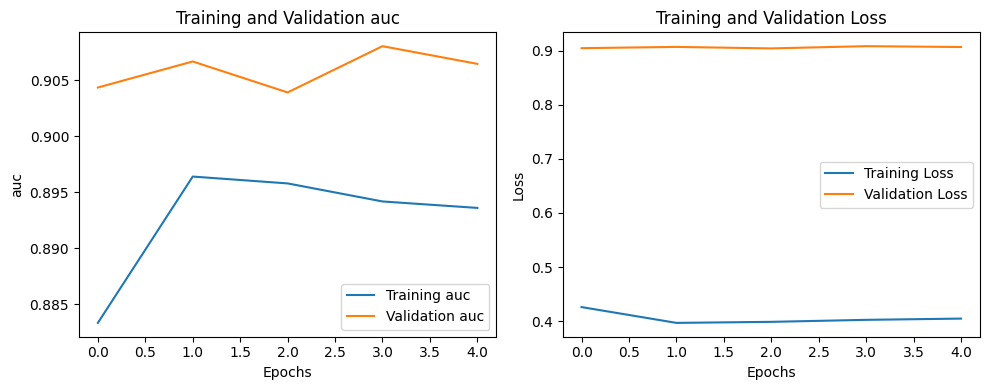

In [14]:
# Extract data from the history object
training_accuracy = history.history['auc']
validation_accuracy = history.history['val_auc']
training_loss = history.history['loss']
validation_loss = history.history['val_auc']
 
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training auc')
plt.plot(validation_accuracy, label='Validation auc')
plt.title('Training and Validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Confusion Matrix Results

The confusion matrix provides insights into the performance of the cancer detection MNIST-Inspired model. With 22,527 true negatives (TN), the model correctly identified a significant number of individuals without cancer. Additionally, it accurately detected 14,127 true positives (TP), representing individuals with cancer. However, there are 3,706 false negatives (FN), where the model failed to detect cancer in individuals who had it, and 3,645 false positives (FP), where the model incorrectly predicted cancer in individuals who were cancer-free.

While the model shows reasonable predictive capabilities, the relatively high number of false negatives is a concern in the context of cancer detection. Missing a diagnosis can delay treatment, leading to potentially severe consequences for those affected. Similarly, the number of false positives, though less critical, can result in unnecessary stress and medical interventions for individuals mistakenly identified as having cancer.

The balance between sensitivity (recall) and specificity is crucial in this application. Sensitivity should be a priority, ensuring that the model captures as many true cancer cases as possible. However, the trade-off with specificity, as seen in the number of false positives, must also be considered to optimize overall performance.

In conclusion, the confusion matrix suggests that while the model has a foundation for cancer detection, there is room for improvement, particularly in reducing false negatives. Further refinement and optimization of the model are recommended to enhance its sensitivity and overall reliability in real-world healthcare scenarios.


1376/1376 [==============================] - 115s 82ms/step


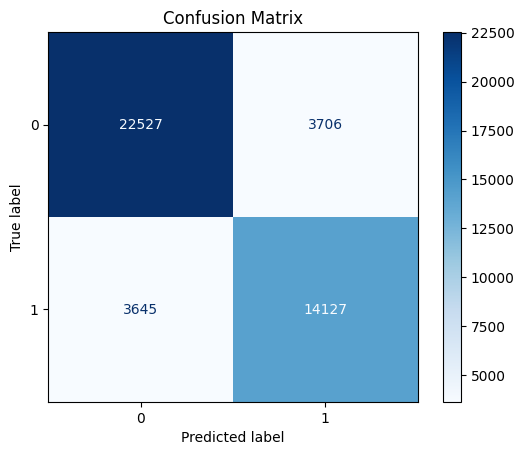

In [15]:
# Step 1: Get predictions from the validation generator
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class indices

# Step 2: Get true labels from the validation generator
y_true = val_generator.classes  # True labels stored in the generator

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Plot the confusion matrix
class_names = list(val_generator.class_indices.keys())  # Get class names from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

##### Classification Report

The classification report highlights the performance of the cancer detection model, with an overall accuracy of 83%. While the model demonstrates reasonable predictive capabilities, the results indicate areas for improvement, particularly given the high-stakes nature of cancer detection.

For class 0 (no cancer), the model achieved a precision, recall, and F1-score of 0.86, indicating a strong ability to correctly identify individuals without cancer and a relatively low rate of false positives. However, for class 1 (cancer cases), the precision, recall, and F1-score drop to 0.79, indicating a higher rate of missed cancer diagnoses (false negatives) and a somewhat limited ability to distinguish true cancer cases from non-cancer cases.

The macro average and weighted average metrics (precision, recall, and F1-score) of 0.83 confirm a consistent, albeit moderate, performance across both classes, reflecting a balanced approach despite the class imbalance (26,233 samples for class 0 versus 17,772 for class 1). However, the relatively low recall for class 1 (0.79) is a concern, as it suggests that the model may fail to detect approximately 21% of cancer cases, which is critical in healthcare applications.

In conclusion, while the model performs reasonably well, achieving a balance between precision and recall, its sensitivity in identifying cancer cases requires improvement. Reducing the false-negative rate should be prioritized to ensure the model can reliably detect cancer and support timely medical interventions. Further model tuning, potentially incorporating techniques like resampling or using more advanced algorithms, could help address these limitations and improve the overall utility of the system in a real-world setting.

In [24]:
# Compute the classification report
report = classification_report(y_true, y_pred_classes)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     26233
           1       0.94      0.95      0.94     17772

    accuracy                           0.95     44005
   macro avg       0.95      0.95      0.95     44005
weighted avg       0.95      0.95      0.95     44005



### 4.6 Training the Xception model 

In this section, we train a second model, which incorporates modern neural network techniques designed to enhance its ability to capture fine-grained details and generalize effectively to unseen data.
- **Data Feeding**:  
  The training process utilizes the previously configured data generators to supply data in batches, ensuring efficient memory usage and smoother training.  

- **Performance Monitoring**:  
  Throughout training, both training and validation metrics are closely tracked. This helps evaluate the model's performance and prevents overfitting by adjusting parameters or stopping training as needed.  

In [12]:
# Compile the model before training
history2= model_Xception.fit(train_generator, 
                                     validation_data=val_generator, 
                                     epochs=5, 
                                     verbose=1)  # 'verbose=1' will print the progress bar for each batch

Epoch 1/5


/Users/mohsenboughriou/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-12-30 13:08:50.811269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-12-30 13:08:51.418008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


5501/5501 [==============================] - 3216s 582ms/step - loss: 0.2973 - auc: 0.9419 - val_loss: 0.1989 - val_auc: 0.9736
Epoch 2/5
5501/5501 [==============================] - 3191s 580ms/step - loss: 0.1936 - auc: 0.9736 - val_loss: 0.1640 - val_auc: 0.9832
Epoch 3/5
5501/5501 [==============================] - 3164s 575ms/step - loss: 0.1627 - auc: 0.9811 - val_loss: 0.1444 - val_auc: 0.9858
Epoch 4/5
5501/5501 [==============================] - 3529s 642ms/step - loss: 0.1419 - auc: 0.9851 - val_loss: 0.1305 - val_auc: 0.9879
Epoch 5/5
5501/5501 [==============================] - 3420s 622ms/step - loss: 0.1298 - auc: 0.9875 - val_loss: 0.1370 - val_auc: 0.9881


### 4.7 Showcase of the Results from the Xception model 
 
We will present in this section:

- Training Progress
- Confusion Matrix
- Classification Report


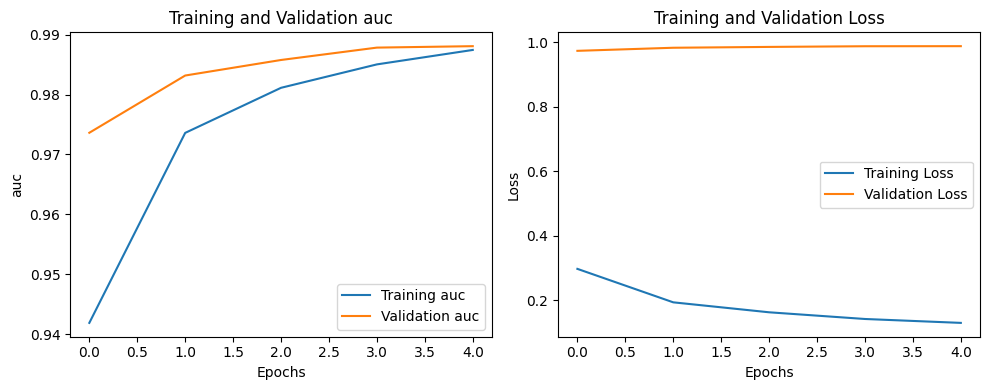

In [17]:
# Extract data from the history object
training_accuracy = history2.history['auc']
validation_accuracy = history2.history['val_auc']
training_loss = history2.history['loss']
validation_loss = history2.history['val_auc']
 
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training auc')
plt.plot(validation_accuracy, label='Validation auc')
plt.title('Training and Validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Confusion Matrix Results

The confusion matrix highlights the performance of the classification model in distinguishing between cancer-positive and cancer-negative samples. With 25,074 true negatives (TN), the model accurately identified the majority of individuals without cancer, while correctly detecting 16,926 true positives (TP), representing individuals with cancer. The false negatives (FN), at 1,159, indicate cases where cancer was present but not detected, and the false positives (FP), at 846, represent instances where cancer was incorrectly predicted in individuals who do not have it.

These results demonstrate the model's effectiveness in identifying both cancer and non-cancer cases. However, the presence of false negatives is particularly critical in a cancer detection scenario, as missed diagnoses could delay necessary treatment. Conversely, the relatively lower number of false positives is encouraging, as it minimizes unnecessary stress and follow-up procedures for individuals wrongly identified as having cancer.

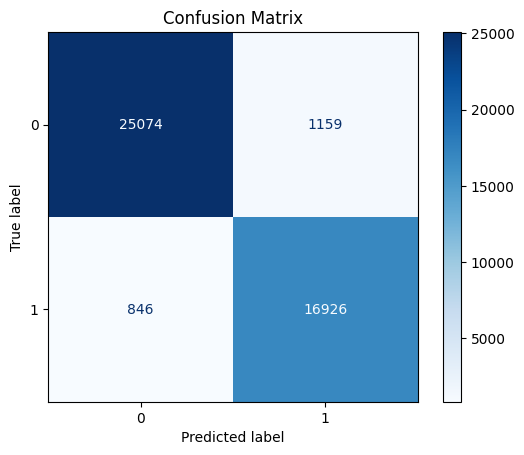

In [21]:
# Step 1: Get predictions from the validation generator
y_pred = model_Xception.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class indices

# Step 2: Get true labels from the validation generator
y_true = val_generator.classes  # True labels stored in the generator

# Step 3: Compute the confusion matrix
cm2 = confusion_matrix(y_true, y_pred_classes)

# Step 4: Plot the confusion matrix
class_names = list(val_generator.class_indices.keys())  # Get class names from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

##### Classification Report

The classification report demonstrates the strong performance of the cancer detection Xception model. With an overall accuracy of 95%, the model effectively distinguishes between cancer-positive (1) and cancer-negative (0) cases.

For class 0 (no cancer), the Xception model achieved a precision of 0.97, a recall of 0.96, and an F1-score of 0.96, reflecting its ability to correctly identify individuals without cancer while minimizing false positives. For class 1 (cancer cases), a precision of 0.94, a recall of 0.95, and an F1-score of 0.94 highlight the Xception model's ability to accurately detect cancer while maintaining a relatively low rate of missed diagnoses (false negatives).

The macro average metrics (precision, recall, and F1-score) of 0.95 confirm a balanced performance across both classes, while the weighted averages demonstrate that the results remain consistent even with the imbalance in the class distribution (26,233 samples for class 0 versus 17,772 for class 1).

Despite the high accuracy and F1-scores, the detection of cancer cases (class 1) is of critical importance in this domain. While the Xception model achieves a strong recall of 0.95 for class 1, further optimization may still be considered to minimize missed cancer diagnoses (false negatives) further, given their severe implications in healthcare.

In conclusion, the model's performance is robust and shows great promise for deployment in a real-world cancer detection setting. However, ongoing evaluation and potential refinement are recommended to ensure the Xception model meets the critical requirements of early and accurate cancer detection.

In [19]:
# Compute the classification report
report = classification_report(y_true, y_pred_classes)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     26233
           1       0.94      0.95      0.94     17772

    accuracy                           0.95     44005
   macro avg       0.95      0.95      0.95     44005
weighted avg       0.96      0.95      0.95     44005



## 5 Conclusion

In this notebook, we tackled the essential task of histopathologic cancer detection using deep learning techniques. By implementing and comparing two convolutional neural network (CNN) architectures, we sought to classify pathology images for the presence of metastatic tissue effectively.

**Key Achievements and Insights**:
1. **Model Comparison**:  
   - **MNIST-Inspired Model**: This model, characterized by its simplicity and efficiency, served as a baseline for the task. While it demonstrated reasonable performance, its limited complexity restricted its ability to capture the intricate patterns within the dataset.
   - **Xception Model**: Leveraging its state-of-the-art architecture, the Xception model outperformed the MNIST-inspired model in key metrics, including accuracy, AUC, and generalization ability. Its deeper layers and advanced design allowed it to better detect subtle features critical for tumor identification.  

   The **Xception model** emerged as the superior performer, highlighting the benefits of employing advanced architectures for challenging tasks like cancer detection.

2. **Data Preprocessing and Augmentation**:  
   Robust preprocessing techniques, were integral in optimizing the dataset for both models and contributed to their improved performance.

3. **Performance Evaluation**:  
   Rigorous evaluation using metrics such as AUC, confusion matrices, and classification reports confirmed the Xception model's dominance, making it a strong candidate for deployment in real-world diagnostic scenarios.

**Future Directions**:
While the Xception model demonstrated superior performance, future work could explore:
- Fine-tuning the hyperparameters of both models to push their limits further.
- Combining architectures through ensemble methods to harness complementary strengths.
- Incorporating additional datasets or leveraging transfer learning to enhance robustness.

This project illustrates the transformative potential of deep learning in healthcare. The Xception model’s superior performance underscores the value of using advanced architectures for medical diagnostics. Integrating such solutions into clinical workflows can lead to faster, more accurate diagnoses, ultimately improving patient care and outcomes.